# Neural Networks

---------------

### 1. Restricted Boltzmann Machine features for digit classification

-------------------


Restricted Boltzmann Machine features for digit classification

For greyscale image data where pixel values can be interpreted as degrees of
blackness on a white background, like handwritten digit recognition, the
Bernoulli Restricted Boltzmann machine model (:class:`BernoulliRBM
<sklearn.neural_network.BernoulliRBM>`) can perform effective non-linear
feature extraction.

In order to learn good latent representations from a small dataset, we
artificially generate more labeled data by perturbing the training data with
linear shifts of 1 pixel in each direction.

This example shows how to build a classification pipeline with a BernoulliRBM
feature extractor and a :class:`LogisticRegression
<sklearn.linear_model.LogisticRegression>` classifier. The hyperparameters
of the entire model (learning rate, hidden layer size, regularization)
were optimized by grid search, but the search is not reproduced here because
of runtime constraints.

Logistic regression on raw pixel values is presented f

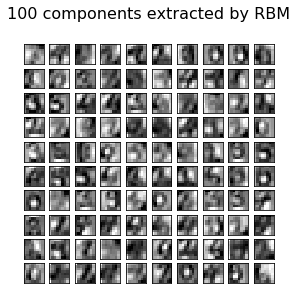

In [2]:
print(__doc__)

# Authors: Yann N. Dauphin, Vlad Niculae, Gabriel Synnaeve
# License: BSD

import numpy as np
import matplotlib.pyplot as plt

from scipy.ndimage import convolve
from sklearn import linear_model, datasets, metrics
from sklearn.model_selection import train_test_split
from sklearn.neural_network import BernoulliRBM
from sklearn.pipeline import Pipeline
from sklearn.base import clone


# #############################################################################
# Setting up

def nudge_dataset(X, Y):
    """
    This produces a dataset 5 times bigger than the original one,
    by moving the 8x8 images in X around by 1px to left, right, down, up
    """
    direction_vectors = [
        [[0, 1, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [1, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 1],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 1, 0]]]

    def shift(x, w):
        return convolve(x.reshape((8, 8)), mode='constant', weights=w).ravel()

    X = np.concatenate([X] +
                       [np.apply_along_axis(shift, 1, X, vector)
                        for vector in direction_vectors])
    Y = np.concatenate([Y for _ in range(5)], axis=0)
    return X, Y


# Load Data
digits = datasets.load_digits()
X = np.asarray(digits.data, 'float32')
X, Y = nudge_dataset(X, digits.target)
X = (X - np.min(X, 0)) / (np.max(X, 0) + 0.0001)  # 0-1 scaling

X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=0)

# Models we will use
logistic = linear_model.LogisticRegression(solver='newton-cg', tol=1,
                                           multi_class='multinomial')
rbm = BernoulliRBM(random_state=0, verbose=True)

rbm_features_classifier = Pipeline(
    steps=[('rbm', rbm), ('logistic', logistic)])

# #############################################################################
# Training

# Hyper-parameters. These were set by cross-validation,
# using a GridSearchCV. Here we are not performing cross-validation to
# save time.
rbm.learning_rate = 0.06
rbm.n_iter = 20
# More components tend to give better prediction performance, but larger
# fitting time
rbm.n_components = 100
logistic.C = 6000

# Training RBM-Logistic Pipeline
rbm_features_classifier.fit(X_train, Y_train)

# Training the Logistic regression classifier directly on the pixel
raw_pixel_classifier = clone(logistic)
raw_pixel_classifier.C = 100.
raw_pixel_classifier.fit(X_train, Y_train)

# #############################################################################
# Evaluation

Y_pred = rbm_features_classifier.predict(X_test)
print("Logistic regression using RBM features:\n%s\n" % (
    metrics.classification_report(Y_test, Y_pred)))

Y_pred = raw_pixel_classifier.predict(X_test)
print("Logistic regression using raw pixel features:\n%s\n" % (
    metrics.classification_report(Y_test, Y_pred)))

# #############################################################################
# Plotting

plt.figure(figsize=(4.2, 4))
for i, comp in enumerate(rbm.components_):
    plt.subplot(10, 10, i + 1)
    plt.imshow(comp.reshape((8, 8)), cmap=plt.cm.gray_r,
               interpolation='nearest')
    plt.xticks(())
    plt.yticks(())
plt.suptitle('100 components extracted by RBM', fontsize=16)
plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)

plt.show()

------------

### 2.  Varying regularization in Multi-layer Perceptron

---------------


Varying regularization in Multi-layer Perceptron

A comparison of different values for regularization parameter 'alpha' on
synthetic datasets. The plot shows that different alphas yield different
decision functions.

Alpha is a parameter for regularization term, aka penalty term, that combats
overfitting by constraining the size of the weights. Increasing alpha may fix
high variance (a sign of overfitting) by encouraging smaller weights, resulting
in a decision boundary plot that appears with lesser curvatures.
Similarly, decreasing alpha may fix high bias (a sign of underfitting) by
encouraging larger weights, potentially resulting in a more complicated
decision boundary.



/Users/admin/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/admin/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/admin/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/admin/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged 

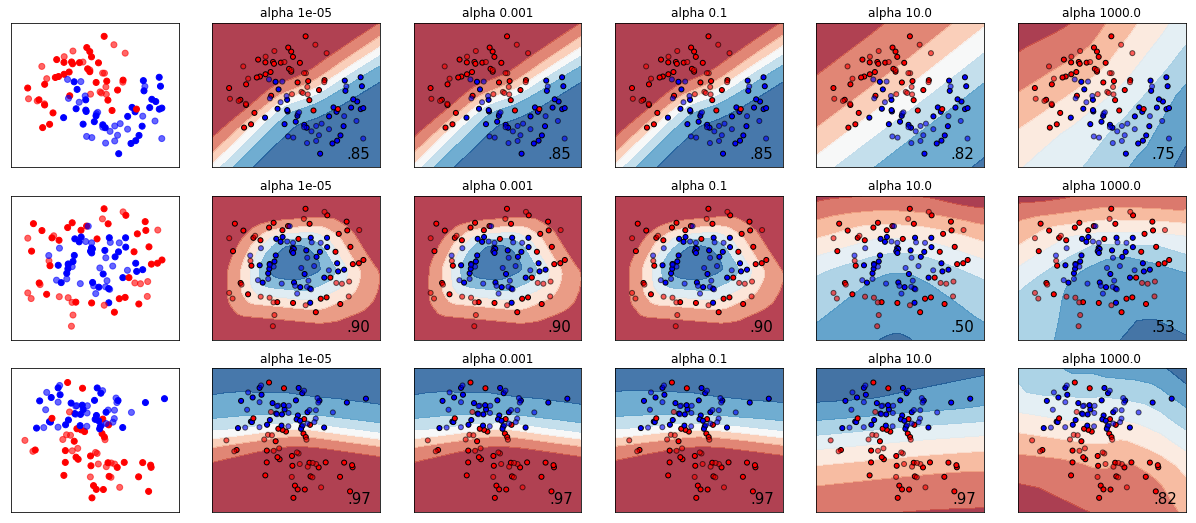

In [4]:
print(__doc__)


# Author: Issam H. Laradji
# License: BSD 3 clause

import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier

h = .02  # step size in the mesh

alphas = np.logspace(-5, 3, 5)
names = ['alpha ' + str(i) for i in alphas]

classifiers = []
for i in alphas:
    classifiers.append(MLPClassifier(alpha=i, random_state=1))

X, y = make_classification(n_features=2, n_redundant=0, n_informative=2,
                           random_state=0, n_clusters_per_class=1)
rng = np.random.RandomState(2)
X += 2 * rng.uniform(size=X.shape)
linearly_separable = (X, y)

datasets = [make_moons(noise=0.3, random_state=0),
            make_circles(noise=0.2, factor=0.5, random_state=1),
            linearly_separable]

figure = plt.figure(figsize=(17, 9))
i = 1
# iterate over datasets
for X, y in datasets:
    # preprocess dataset, split into training and test part
    X = StandardScaler().fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4)

    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # just plot the dataset first
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright)
    # and testing points
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6)
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    i += 1

    # iterate over classifiers
    for name, clf in zip(names, classifiers):
        ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)

        # Plot the decision boundary. For that, we will assign a color to each
        # point in the mesh [x_min, x_max]x[y_min, y_max].
        if hasattr(clf, "decision_function"):
            Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        else:
            Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)

        # Plot also the training points
        ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
                   edgecolors='black', s=25)
        # and testing points
        ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright,
                   alpha=0.6, edgecolors='black', s=25)

        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.set_xticks(())
        ax.set_yticks(())
        ax.set_title(name)
        ax.text(xx.max() - .3, yy.min() + .3, ('%.2f' % score).lstrip('0'),
                size=15, horizontalalignment='right')
        i += 1

figure.subplots_adjust(left=.02, right=.98)
plt.show()

-------------

### 4. Visualization of MLP weights on MNIST

------------------------


Varying regularization in Multi-layer Perceptron

A comparison of different values for regularization parameter 'alpha' on
synthetic datasets. The plot shows that different alphas yield different
decision functions.

Alpha is a parameter for regularization term, aka penalty term, that combats
overfitting by constraining the size of the weights. Increasing alpha may fix
high variance (a sign of overfitting) by encouraging smaller weights, resulting
in a decision boundary plot that appears with lesser curvatures.
Similarly, decreasing alpha may fix high bias (a sign of underfitting) by
encouraging larger weights, potentially resulting in a more complicated
decision boundary.

Iteration 1, loss = 0.32009978
Iteration 2, loss = 0.15347534
Iteration 3, loss = 0.11544755
Iteration 4, loss = 0.09279764
Iteration 5, loss = 0.07889367
Iteration 6, loss = 0.07170497
Iteration 7, loss = 0.06282111
Iteration 8, loss = 0.05529723
Iteration 9, loss = 0.04960484
Iteration 10, loss = 0.04645355


/Users/admin/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Training set score: 0.986800
Test set score: 0.970000


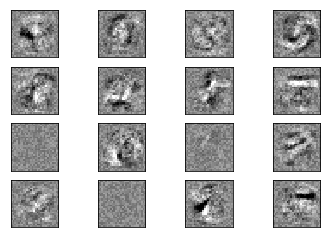

In [6]:
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.neural_network import MLPClassifier

print(__doc__)

# Load data from https://www.openml.org/d/554
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
X = X / 255.

# rescale the data, use the traditional train/test split
X_train, X_test = X[:60000], X[60000:]
y_train, y_test = y[:60000], y[60000:]

# mlp = MLPClassifier(hidden_layer_sizes=(100, 100), max_iter=400, alpha=1e-4,
#                     solver='sgd', verbose=10, tol=1e-4, random_state=1)
mlp = MLPClassifier(hidden_layer_sizes=(50,), max_iter=10, alpha=1e-4,
                    solver='sgd', verbose=10, tol=1e-4, random_state=1,
                    learning_rate_init=.1)

mlp.fit(X_train, y_train)
print("Training set score: %f" % mlp.score(X_train, y_train))
print("Test set score: %f" % mlp.score(X_test, y_test))

fig, axes = plt.subplots(4, 4)
# use global min / max to ensure all weights are shown on the same scale
vmin, vmax = mlp.coefs_[0].min(), mlp.coefs_[0].max()
for coef, ax in zip(mlp.coefs_[0].T, axes.ravel()):
    ax.matshow(coef.reshape(28, 28), cmap=plt.cm.gray, vmin=.5 * vmin,
               vmax=.5 * vmax)
    ax.set_xticks(())
    ax.set_yticks(())

plt.show()